# Análisis Exploratorio de Datos (EDA)

En esta sección revisamos las tres bases de datos disponibles para el proyecto:
- **Demanda acumulada** (2017-01 a 2022-04) → para pronóstico de demanda.  
- **Alpha / Beta** → para clasificación supervisada.  
- **to_predict** → datos nuevos que se completarán con los modelos.  

---

### Setup

In [20]:
import pandas as pd
from IPython.display import display
import unicodedata
import matplotlib.pyplot as plt

### Carga de datos

In [ ]:
# Cargar datasets
df_demand = pd.read_csv("../data/raw/dataset_demand_acumulate.csv")
df_alpha = pd.read_csv("../data/raw/dataset_alpha_betha.csv")
df_pred = pd.read_csv("../data/raw/to_predict.csv")

In [1]:
# Visulazación inicial de confirmación y conocimiento
for name, df in [("df_demand", df_demand), ("df_alpha", df_alpha), ("df_pred", df_pred)]:
    display(df.head())

NameError: name 'df_demand' is not defined

### Exploración inicial

In [13]:
# 1. Info rápida
def quick_info(df, name):
    return pd.DataFrame({
        "Columnas": df.columns,
        "Tipo": df.dtypes.astype(str),
        "Nulos": df.isna().sum(),
        "Únicos": df.nunique(),
        "Duplicados": [df.duplicated().sum()] + [""]*(len(df.columns)-1)
    })

# 2. Resumen de ambos DataFrames
info_demand = quick_info(df_demand, "df_demand")
info_alpha  = quick_info(df_alpha, "df_alpha")
df_pred  = quick_info(df_pred, "df_pred")

print("=== df_demand ===")
display(info_demand)

print("=== df_alpha ===")
display(info_alpha)

print("=== df_pred ===")
display(df_pred)

=== df_demand ===


,Columnas,Tipo,Nulos,Únicos,Duplicados
year_month,year_month,object,0,64,0
Demand,Demand,float64,0,64,


=== df_alpha ===


,Columnas,Tipo,Nulos,Únicos,Duplicados
autoID,autoID,object,0,7043,0
SeniorCity,SeniorCity,int64,0,2,
Partner,Partner,object,0,2,
Dependents,Dependents,object,0,2,
Service1,Service1,object,0,2,
Service2,Service2,object,0,3,
Security,Security,object,0,3,
OnlineBackup,OnlineBackup,object,0,3,
DeviceProtection,DeviceProtection,object,0,3,
TechSupport,TechSupport,object,0,3,


=== df_pred ===


,Columnas,Tipo,Nulos,Únicos,Duplicados
Columnas,Columnas,object,0,16,0
Tipo,Tipo,object,0,3,
Nulos,Nulos,int64,0,2,
Únicos,Únicos,int64,0,4,
Duplicados,Duplicados,object,0,2,


No se observan nulos, ni duplicados.

### Formateo de variables

In [ ]:

def normalize_text(s):
    if pd.isna(s):
        return s
    s = str(s).strip().upper()
    s = ''.join(c for c in unicodedata.normalize("NFKD", s) if unicodedata.category(c) != "Mn")
    return s

# ---------- df_demand ----------
# parsear fecha y asegurar numérico (nombres reales: year_month, Demand)
df_demand["year_month"] = pd.to_datetime(df_demand["year_month"], format="%Y-%m", errors="coerce")
df_demand["Demand"] = pd.to_numeric(df_demand["Demand"], errors="coerce")
df_demand = df_demand.sort_values("year_month").reset_index(drop=True)

# ---------- df_alpha ----------
# normalizar texto en columnas object (excepto autoID)
obj_cols = [c for c in df_alpha.select_dtypes(include="object").columns if c != "autoID"]
for c in obj_cols:
    df_alpha[c] = df_alpha[c].apply(normalize_text)

# unificar etiquetas erróneas y asegurar tipos numéricos
if "Class" in df_alpha.columns:
    df_alpha["Class"] = df_alpha["Class"].replace({"BETHA": "BETA"}) 
    df_alpha["Class"] = df_alpha["Class"].astype("category")

if "Demand" in df_alpha.columns:
    df_alpha["Demand"] = pd.to_numeric(df_alpha["Demand"], errors="coerce")

if "Charges" in df_alpha.columns:
    df_alpha["Charges"] = pd.to_numeric(df_alpha["Charges"], errors="coerce")

# ---------- df_pred ----------
# aplicar misma normalización que en df_alpha
for c in df_pred.select_dtypes(include="object").columns:
    df_pred[c] = df_pred[c].apply(normalize_text)

if "Charges" in df_pred.columns:
    df_pred["Charges"] = pd.to_numeric(df_pred["Charges"], errors="coerce")

# ---------- checks rápidos ----------
print("df_demand:", df_demand.shape)
print(df_demand.dtypes)

print("\ndf_alpha:", df_alpha.shape)
print(df_alpha[["Demand", "Charges"]].describe(include="all"))
print("\nClass distribution:\n", df_alpha["Class"].value_counts(dropna=False))

print("\ndf_pred:", df_pred.shape)
print(df_pred.dtypes)


df_demand: (64, 2)
year_month    datetime64[ns]
Demand               float64
dtype: object

df_alpha: (7043, 16)
            Demand      Charges
count  7032.000000  7043.000000
mean   2283.300441    64.761692
std    2266.771362    30.090047
min      18.800000    18.250000
25%     401.450000    35.500000
50%    1397.475000    70.350000
75%    3794.737500    89.850000
max    8684.800000   118.750000

Class distribution:
 Class
ALPHA    5174
BETA     1869
Name: count, dtype: int64

df_pred: (5, 5)
Columnas      object
Tipo          object
Nulos          int64
Únicos         int64
Duplicados    object
dtype: object


Se observa un desbalanceo de clases: ALPHA ≈ 74%, BETA ≈ 26%.

### Tendencia y estacionalidad de la demanda
Visualizamos la serie de tiempo completa y analizamos si hay patrones de tendencia o estacionalidad.

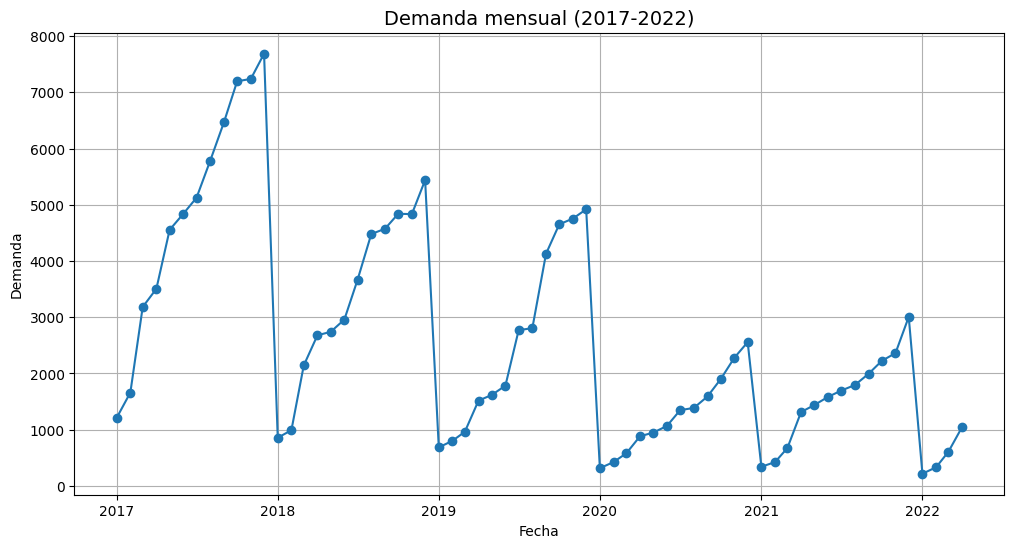

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_demand["year_month"], df_demand["Demand"], marker="o")
plt.title("Demanda mensual (2017-2022)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.grid(True)
plt.show()

Se observa una clara estacionalidad, con caídas abruptas entre años. Esto sugiere que el modelo necesitará capturar patrones estacionales anuales. Hay tendencias y cambios de nivel, por lo que no es estacionaria.